In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pandas as pd
import math
#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

# Problem 1

## 1) Download the data

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))

## 2) Find and describe how the background changes

In [3]:
df = pd.DataFrame(data).transpose()
df.columns = ["gps_time", "solar_phase", "longitude", "count"]

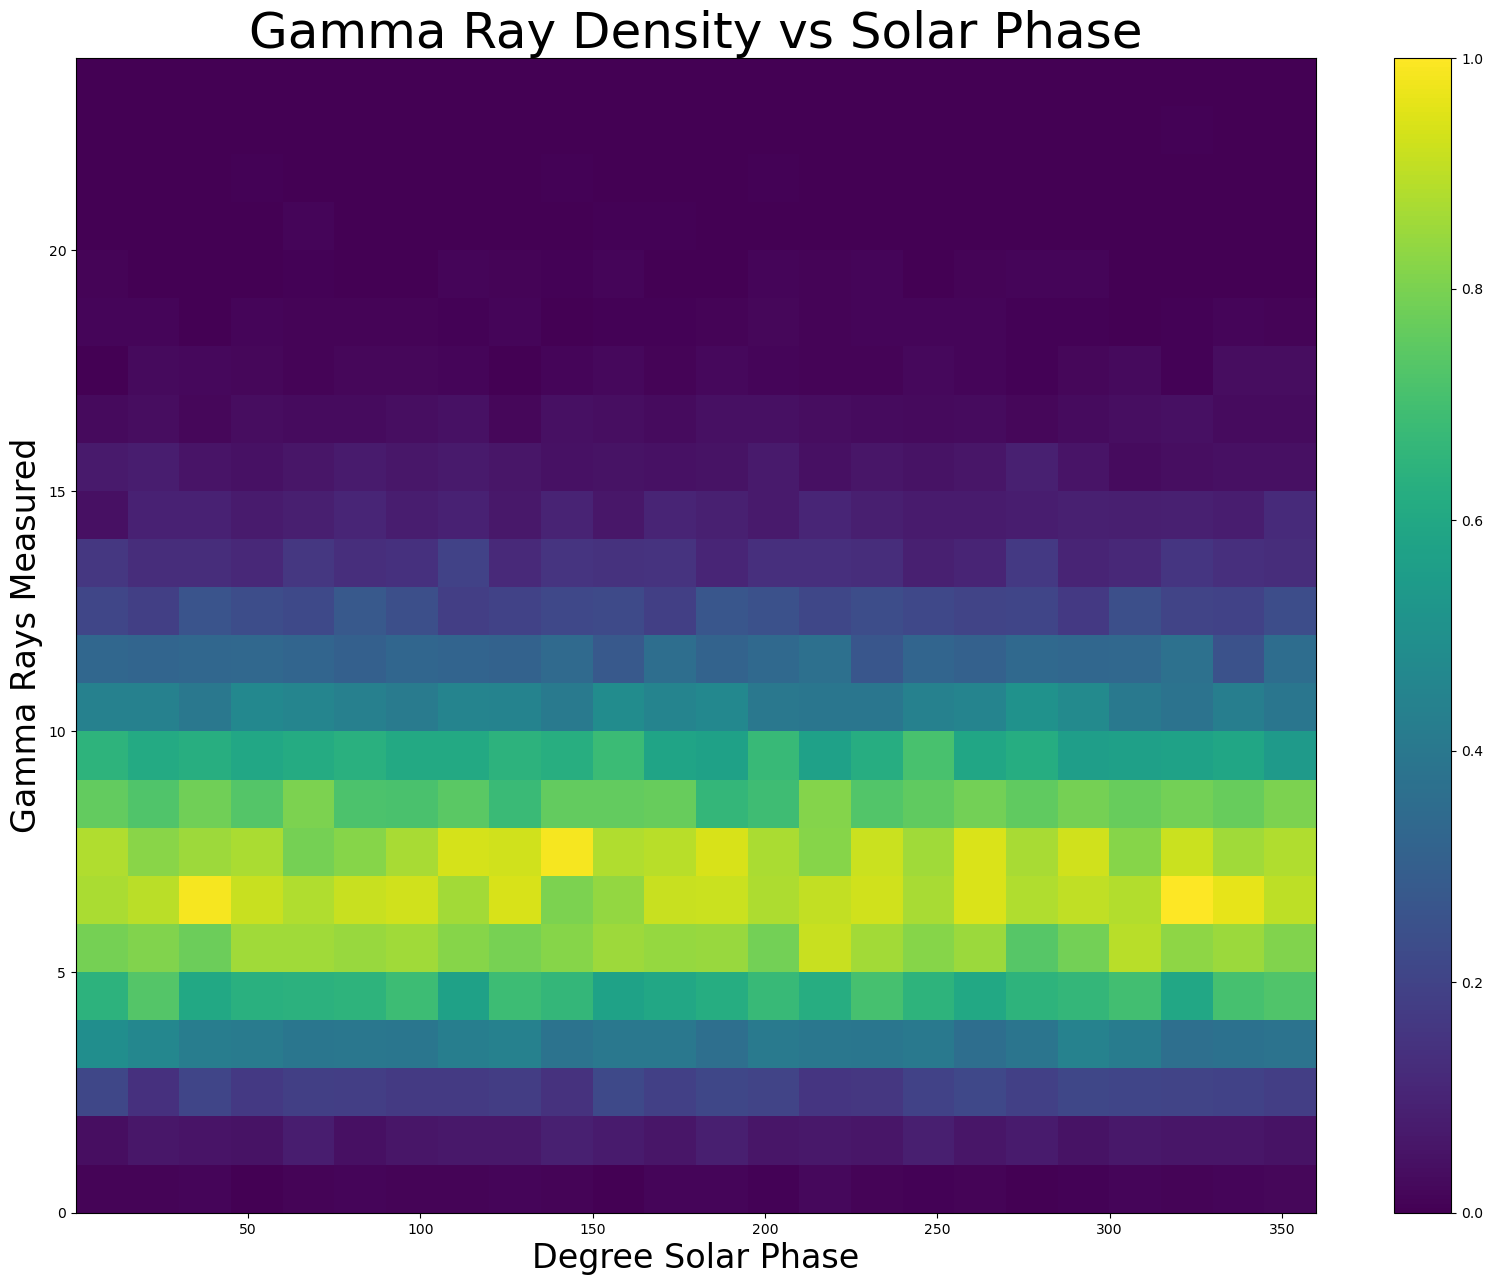

In [21]:
fig, ax = plt.subplots(1,1)
fig.colorbar(plt.cm.ScalarMappable(), ax=ax)
plt.hist2d(df['solar_phase'][::500], df['count'][::500], bins = 24)
plt.xlabel("Degree Solar Phase", fontsize = 24)
plt.ylabel("Gamma Rays Measured", fontsize = 24)
plt.title("Gamma Ray Density vs Solar Phase", fontsize = 36)
plt.show()

We can see in the graph above the density of gamma ray measurement that there is very little to no dependance on the solar phase. At all points of solar phase, the density is relatively stable.

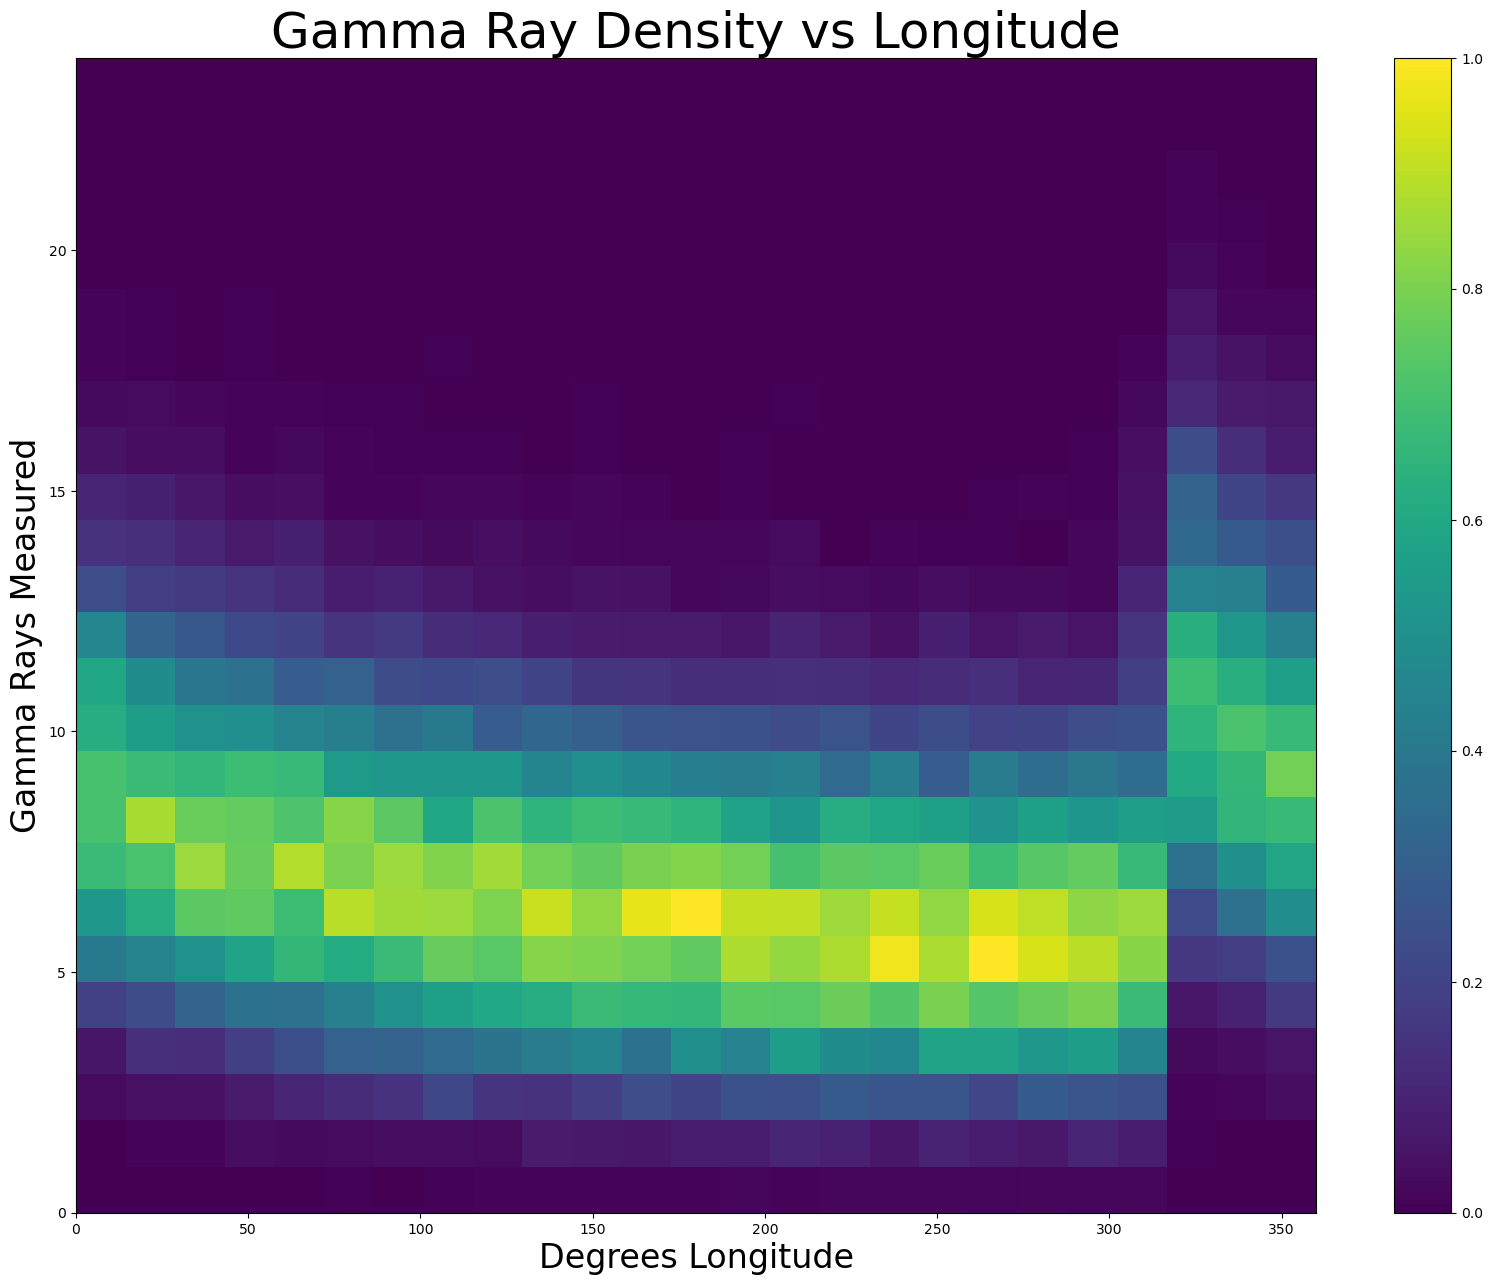

In [25]:
fig, ax = plt.subplots(1,1)
fig.colorbar(plt.cm.ScalarMappable(), ax=ax)
plt.xlabel("Degrees Longitude", fontsize = 24)
plt.ylabel("Gamma Rays Measured", fontsize = 24)
plt.title("Gamma Ray Density vs Longitude", fontsize = 36)
plt.hist2d(df['longitude'][::502], df['count'][::502], bins = 25)
plt.show()

In [6]:
counts = [0]*3600
for i in range(len(df["count"][::54])):
    counts[math.floor(df["longitude"][i*54]*10)] += int(df["count"][i*54])

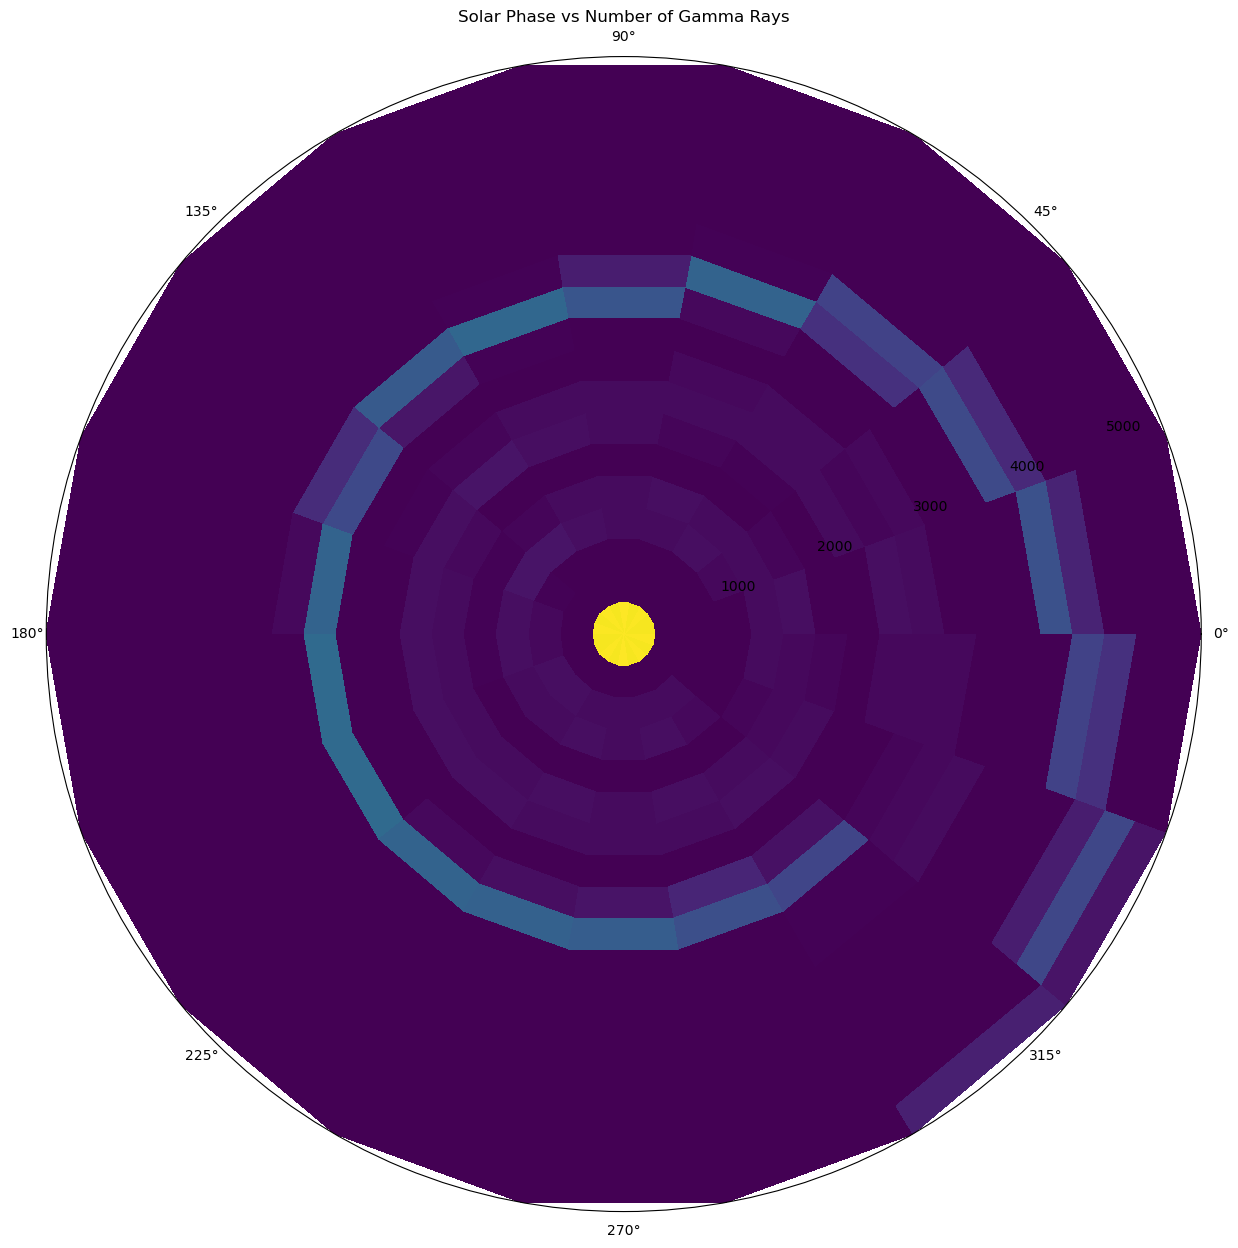

In [24]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
plt.title("Solar Phase vs Number of Gamma Rays")
plt.hist2d(np.linspace(0,2*np.pi,3600), counts, bins = 18)

plt.show()

In the above two graphs we can see that the solar phase has little impact on the distribution of the number of gama rays that we see. We see 

In [8]:
means = [0]*54000
for i in range(54000):
    means[i] = df["count"][i::54000].mean()


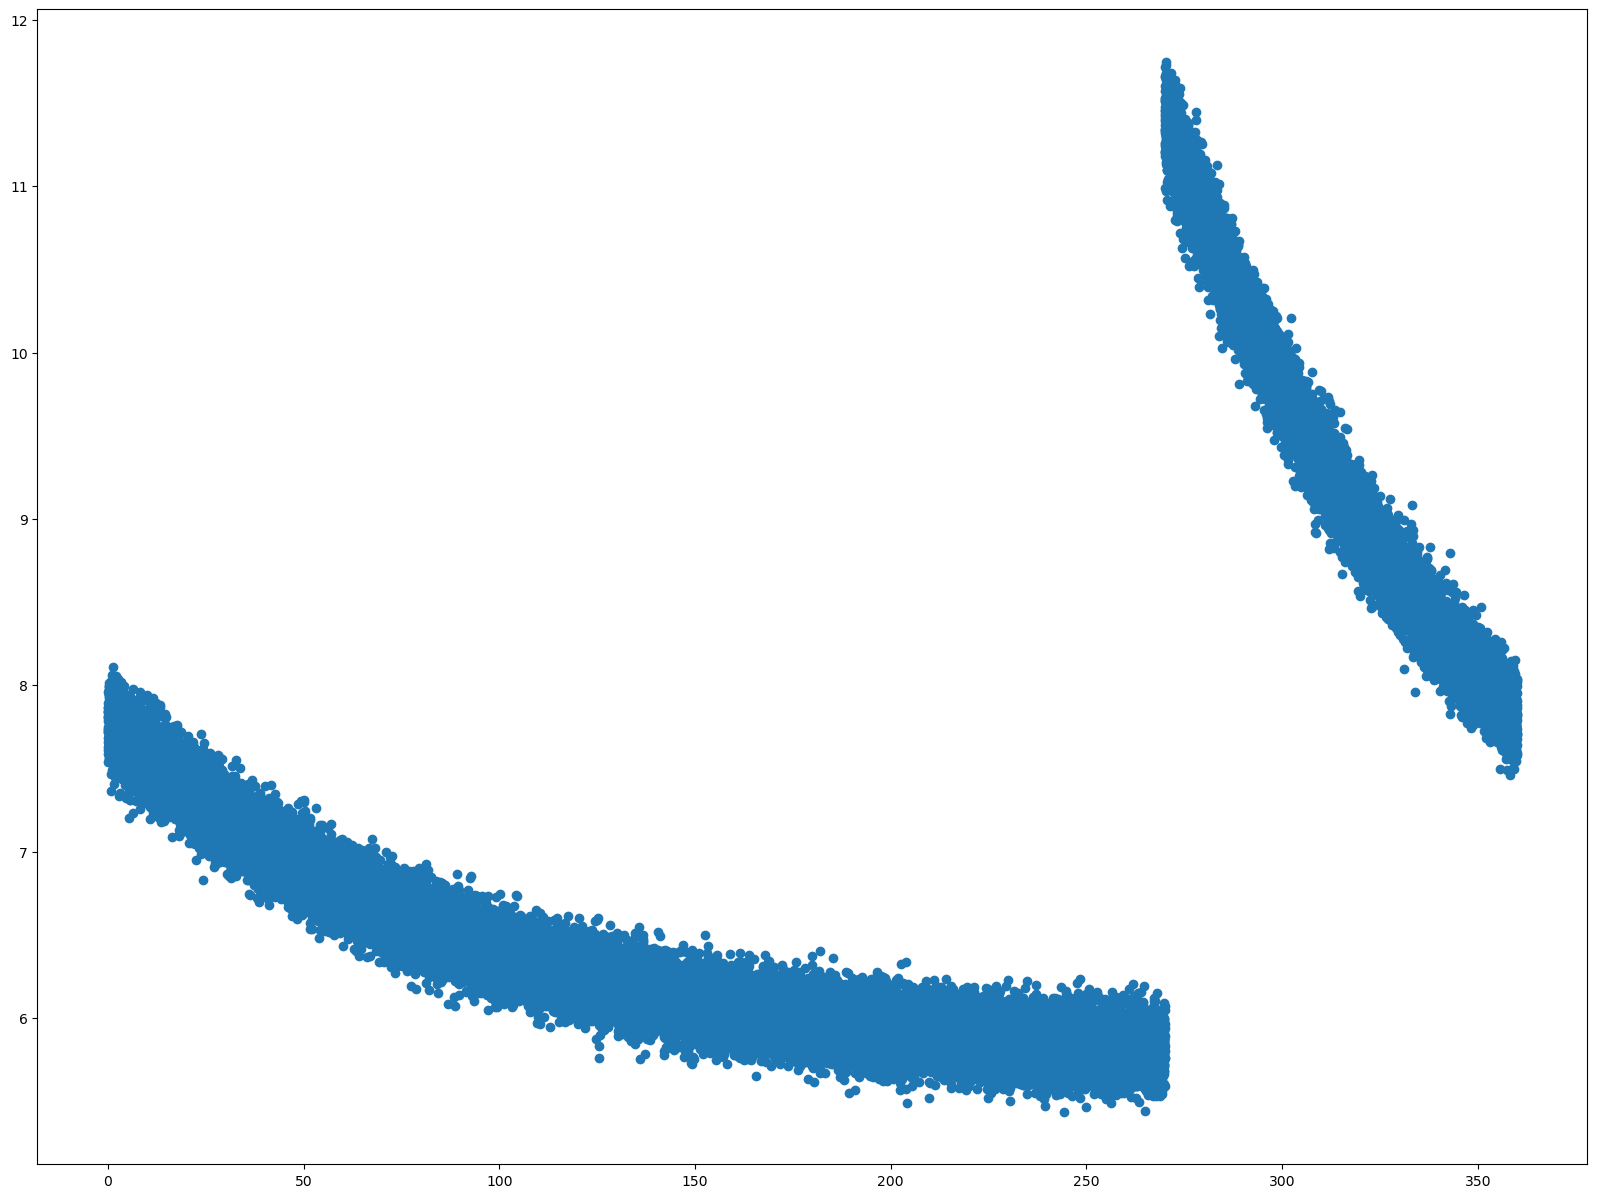

In [9]:
plt.scatter(x = np.linspace(0,360,54000),y = means)
plt.show()

In [10]:
rearanged_means = means[40500:] + means[:40500]

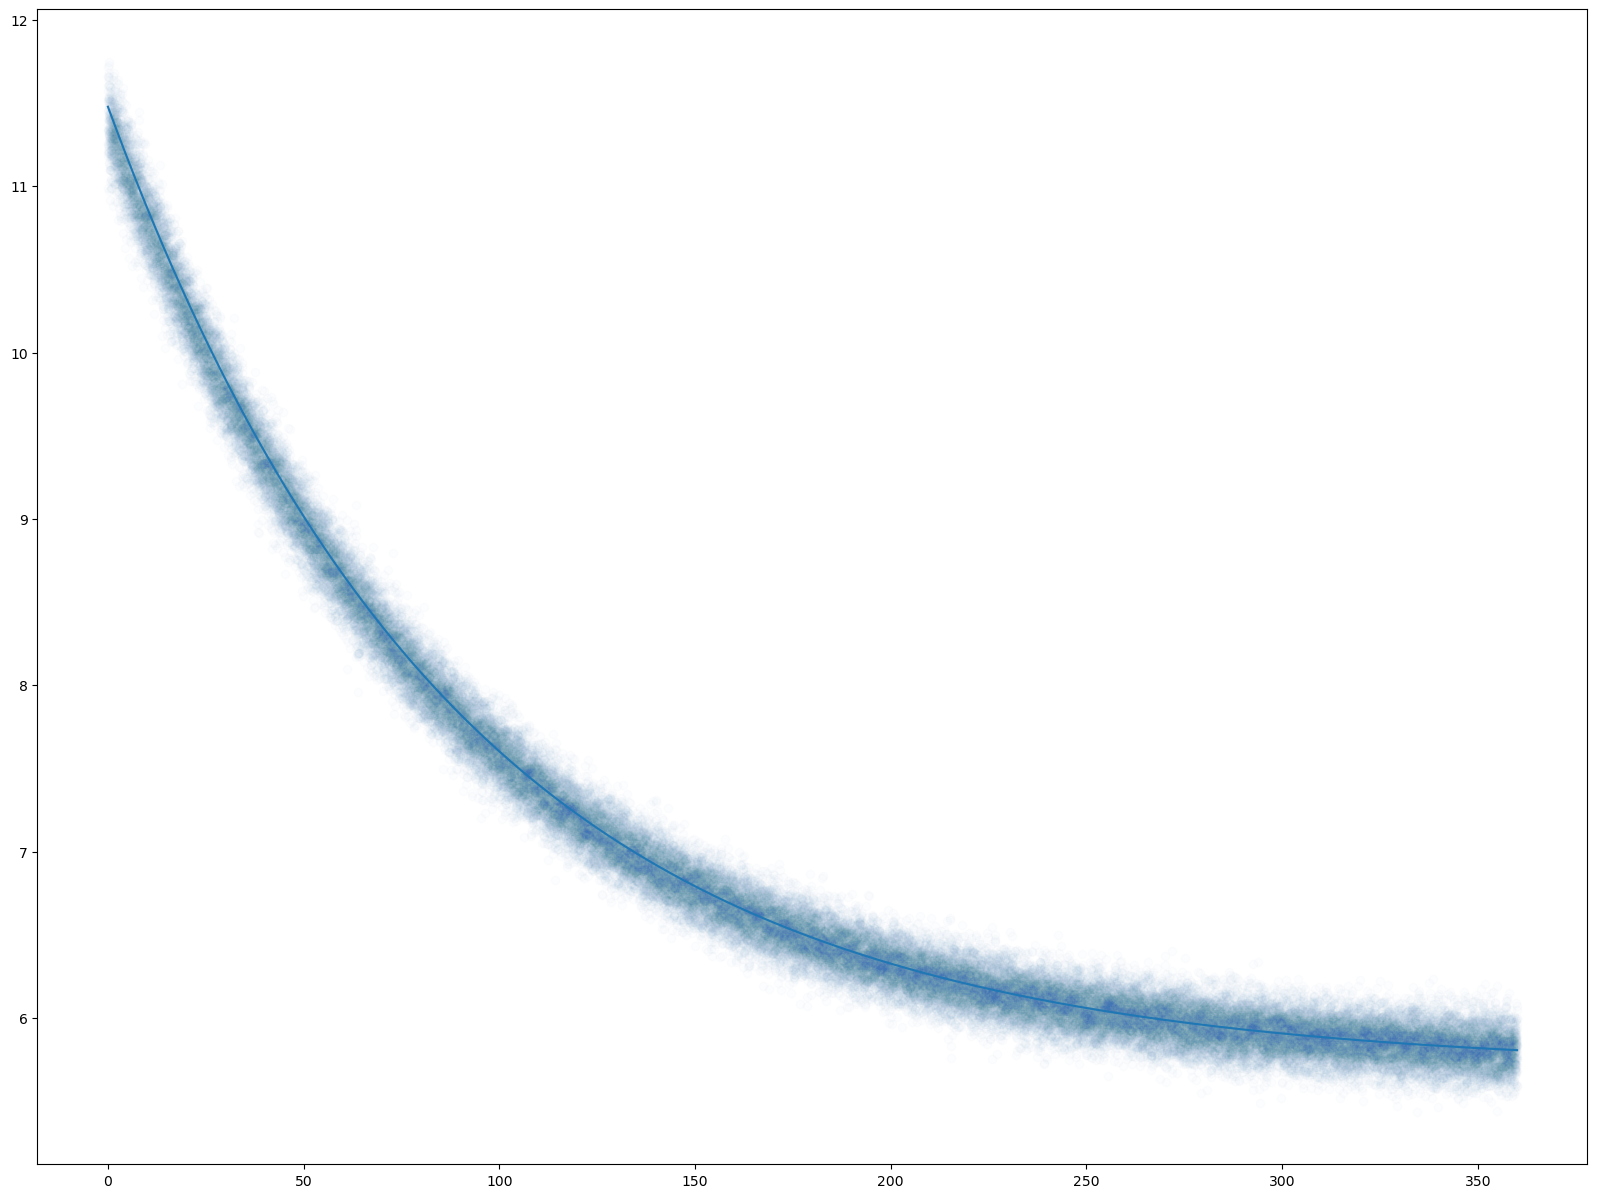

In [92]:
x = np.linspace(0,360,54000)
y = scipy.stats.expon.pdf(x, scale = 90)*520+5.7
plt.scatter(x=x,y = rearanged_means, alpha = 0.01)
plt.plot(x, y)
plt.show()

In [ ]:
counts